In [1]:
%config InlineBackend.figure_formats = ['svg']

In [3]:
from time import time

import numpy as np
import rustworkx as rx

import matplotlib.pyplot as plt

from qiskit import transpile
from qiskit.circuit import Parameter
from qiskit.opflow import VectorStateFn

from qiskit.circuit.library import EfficientSU2
from qiskit.primitives import Estimator
from qiskit.algorithms import NumPyEigensolver as ClassicalEigensolver, MinimumEigensolver, VQEResult
from qiskit.algorithms.optimizers import SLSQP, COBYLA, L_BFGS_B, ADAM, GradientDescent, NFT

from qiskit_nature.problems.second_quantization.lattice import Lattice
from qiskit_nature.mappers.second_quantization import LogarithmicMapper

from heisenberg_model import HeisenbergModel

In [4]:
class VQE(MinimumEigensolver):
    
    def __init__(self, estimator, circuit, optimizer, callback=None):
        self._estimator = estimator
        self._circuit = circuit
        self._optimizer = optimizer
        self._callback = callback
        
    def compute_minimum_eigenvalue(self, operators, aux_operators=None):
                
        def objective(x):
            job = self._estimator.run([self._circuit], [operators], [x])
            estimator_result = job.result()
            value = estimator_result.values[0]
            if self._callback is not None:
                self._callback(value)
            return value
            
        x0 = np.pi/4 * np.random.rand(self._circuit.num_parameters)
        
        res = self._optimizer.minimize(objective, x0=x0)
        

        result = VQEResult()
        result.cost_function_evals = res.nfev
        result.eigenvalue = res.fun
        result.optimal_parameters = res.x
        return result

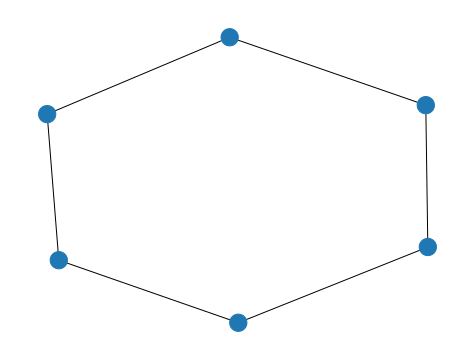

In [5]:
num_sites = 6
t = 1.0

graph = rx.PyGraph(multigraph=False)
graph.add_nodes_from(range(num_sites))
edge_list = [
    (0, 1, t),
    (1, 2, t),
    (2, 3, t),
    (3, 4, t),
    (4, 5, t),
    (5, 0, t),
]

graph.add_edges_from(edge_list)
line_unit_cell = Lattice(graph)

line_unit_cell.draw()
plt.show()

In [6]:
heisenberg_model = HeisenbergModel.uniform_parameters(
    lattice=line_unit_cell,
    uniform_interaction=1.0,
    uniform_onsite_potential=0.0,
)

logarithmic_mapper = LogarithmicMapper()
hamiltonian = 4 * logarithmic_mapper.map(heisenberg_model.second_q_ops().simplify())
hamiltonian

PauliSumOp(SparsePauliOp(['ZZIIII', 'IZZIII', 'IIZZII', 'IIIZZI', 'ZIIIIZ', 'IIIIZZ', 'YYIIII', 'IYYIII', 'IIYYII', 'IIIYYI', 'YIIIIY', 'IIIIYY', 'XXIIII', 'IXXIII', 'IIXXII', 'IIIXXI', 'XIIIIX', 'IIIIXX'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j]), coeff=1)

In [23]:
exact_solver = ClassicalEigensolver(k=1)
exact_result = exact_solver.compute_eigenvalues(hamiltonian)
print(exact_result.eigenvalues)

gs_energy = exact_result.eigenvalues[0]

[-11.21110255]


In [52]:
exact_result.eigenstates[0].primitive.draw("latex")

<IPython.core.display.Latex object>

In [50]:
for index, amplitude in enumerate(exact_result.eigenstates[0].primitive.data):
    if not np.isclose(np.abs(amplitude), 0):
        print(f"{index:0{num_sites}b}: {np.abs(amplitude)}, {np.angle(amplitude) - np.angle(exact_result.eigenstates[0].primitive.data[7]):.2f}")

000111: 0.0629206215186987, 0.00
001011: 0.20781269586291368, 3.14
001101: 0.2078126958629141, 0.00
001110: 0.06292062151869886, 3.14
010011: 0.20781269586291398, 0.00
010101: 0.47854601324452756, 3.14
010110: 0.20781269586291404, 0.00
011001: 0.20781269586291398, 0.00
011010: 0.20781269586291368, 3.14
011100: 0.06292062151869868, 0.00
100011: 0.06292062151869883, 3.14
100101: 0.207812695862914, 0.00
100110: 0.2078126958629137, 3.14
101001: 0.20781269586291376, 3.14
101010: 0.47854601324452595, 0.00
101100: 0.20781269586291368, 3.14
110001: 0.06292062151869876, 0.00
110010: 0.2078126958629138, 3.14
110100: 0.20781269586291395, 0.00
111000: 0.06292062151869882, 3.14


In [65]:
0.47854601324452756 ** 2

0.22900628679223153

In [62]:
(0.47854601324452756 / 0.20781269586291398) ** 2  

166.62490369794028

In [58]:
(0.47854601324452756 / 0.0629206215186987) ** 2 / (2 + np.sqrt(13))

10.319129620114722

In [60]:
(0.20781269586291368 / 0.0629206215186987) ** 2 * (2 + np.sqrt(13))

61.14718584144397

Ground State


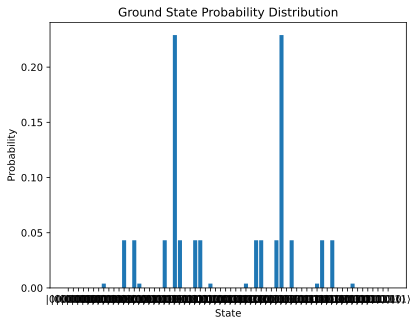

Probabilities
	|000000> ==> 0.000
	|000001> ==> 0.000
	|000010> ==> 0.000
	|000011> ==> 0.000
	|000100> ==> 0.000
	|000101> ==> 0.000
	|000110> ==> 0.000
	|000111> ==> 0.004
	|001000> ==> 0.000
	|001001> ==> 0.000
	|001010> ==> 0.000
	|001011> ==> 0.043
	|001100> ==> 0.000
	|001101> ==> 0.043
	|001110> ==> 0.004
	|001111> ==> 0.000
	|010000> ==> 0.000
	|010001> ==> 0.000
	|010010> ==> 0.000
	|010011> ==> 0.043
	|010100> ==> 0.000
	|010101> ==> 0.229
	|010110> ==> 0.043
	|010111> ==> 0.000
	|011000> ==> 0.000
	|011001> ==> 0.043
	|011010> ==> 0.043
	|011011> ==> 0.000
	|011100> ==> 0.004
	|011101> ==> 0.000
	|011110> ==> 0.000
	|011111> ==> 0.000
	|100000> ==> 0.000
	|100001> ==> 0.000
	|100010> ==> 0.000
	|100011> ==> 0.004
	|100100> ==> 0.000
	|100101> ==> 0.043
	|100110> ==> 0.043
	|100111> ==> 0.000
	|101000> ==> 0.000
	|101001> ==> 0.043
	|101010> ==> 0.229
	|101011> ==> 0.000
	|101100> ==> 0.043
	|101101> ==> 0.000
	|101110> ==> 0.000
	|101111> ==> 0.000
	|110000> ==> 0.000
	|1100

In [33]:
print(f"Ground State")

states = [f"{state:0{num_sites}b}" for state in range(2**num_sites)]
probabilities = [ np.abs(exact_result.eigenstates[0].primitive.data[state]) ** 2 for state in range(2**num_sites) ]

# plt.figure(figsize=(70, 6))
plt.bar([f"$|{state}\\rangle$" for state in states], probabilities)
plt.xlabel("State")
plt.ylabel("Probability")
plt.title(f"Ground State Probability Distribution")
plt.show()

print("Probabilities")
for state, probability in zip(states, probabilities):
    print(f"\t|{state}> ==> {probability:.3f}")

print()